# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Functions definition

In [2]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr

In [3]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [4]:
def RMSE_emulator(pc1, pc2, pc3, pc4, pc5) : 
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_SW.npy')
    
    E_pc1 = []
    E_pc2 = []
    E_pc3 = []
    E_pc4 = []
    E_pc5 = []
    E_tmp = []

    for i in pc1:
        tmp = (i-U_obs[0])**2
        E_pc1.append(tmp)
    
    for j in pc2:
        tmp = (j-U_obs[1])**2
        E_pc2.append(tmp)

    for k in pc3:
        tmp = (k-U_obs[2])**2
        E_pc3.append(tmp)
    
    for l in pc4:
        tmp = (l-U_obs[3])**2
        E_pc4.append(tmp)
    
    for m in pc5:
        tmp = (m-U_obs[4])**2
        E_pc5.append(tmp)

    for n in range(0,len(E_pc1),1) :    
        tmp = E_pc1[n]+E_pc2[n]+E_pc3[n]+E_pc4[n]+E_pc5[n]
        E_tmp.append(tmp/5)

    
    E = sqrt(E_tmp)
    
    
    return E

In [5]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_SW.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [7]:
def Lasso_pred_eof1(x,alpha):
    
    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_SW.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
       
    # Let's use the model equation : 

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    R = lasso.intercept_
    Coeffs = pd.DataFrame([lasso.coef_]).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy', R)

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred
    

In [11]:
def Lasso_pred_eof2(x,alpha) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_SW.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    R = lasso.intercept_
    Coeffs = pd.DataFrame([lasso.coef_]).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy', R)

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred



In [12]:
def Lasso_pred_eof3(x,alpha) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_SW.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    R = lasso.intercept_
    Coeffs = pd.DataFrame([lasso.coef_]).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy', R)

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred


In [13]:
def Lasso_pred_eof4(x,alpha) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_SW.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    R = lasso.intercept_
    Coeffs = pd.DataFrame([lasso.coef_]).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy', R)

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred



In [14]:
def Lasso_pred_eof5(x,alpha) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_SW.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    R = lasso.intercept_
    Coeffs = pd.DataFrame([lasso.coef_]).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy', R)

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [15]:
def Lasso_pred(x, EOF_nb) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_SW.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    R = lasso.intercept_
    Coeffs = pd.DataFrame([lasso.coef_]).iloc[0]
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R

    return y_pred

# Draw bottom line by selecting the best model for each feedback value

In [16]:
E_lasso_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_lasso_pred.npy")
Fdbck_lasso_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
lasso_pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_prediction_eof1_SW.npy')
lasso_pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_prediction_eof2_SW.npy')
lasso_pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_prediction_eof3_SW.npy')
lasso_pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_prediction_eof4_SW.npy')
lasso_pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_prediction_eof5_SW.npy')


E_lasso_pred_df = pd.DataFrame(E_lasso_pred)
E_lasso_pred_df['E_lasso_pred'] = E_lasso_pred
E_lasso_pred_df['Fdbck_pred'] = Fdbck_lasso_pred
E_lasso_pred_df['pc1'] = lasso_pc1
E_lasso_pred_df['pc2'] = lasso_pc2
E_lasso_pred_df['pc3'] = lasso_pc3
E_lasso_pred_df['pc4'] = lasso_pc4
E_lasso_pred_df['pc5'] = lasso_pc5
E_lasso_pred_df = E_lasso_pred_df.drop([0], axis=1)
E_lasso_pred_df

,E_lasso_pred,Fdbck_pred,pc1,pc2,pc3,pc4,pc5
0,1.623360,-1.512419,-1.188638,-1.074937,0.208120,-0.830527,-1.008227
1,1.440651,-1.334161,0.852979,-0.873516,-0.135428,-0.459890,0.197646
2,1.996354,-1.344134,-0.650263,0.800245,-0.038338,-1.103550,0.692037
3,1.733383,-1.528166,-0.110645,-0.002414,-0.183330,-0.191313,-0.469968
4,1.521157,-1.358046,0.350938,-0.589323,0.311577,-1.318056,1.257309
...,...,...,...,...,...,...,...
99995,1.905633,-1.466209,-0.865193,0.456393,-0.549118,-0.411497,-0.144554
99996,1.822684,-1.415162,0.129610,-0.064274,0.646912,-0.583376,-0.820387
99997,1.796161,-1.302962,-0.070619,0.342877,-0.170783,0.589971,-0.361617
99998,0.952764,-1.311885,0.435779,-1.578188,0.222244,0.087385,0.592602


In [17]:
Fdbck_lasso_pred.max()

-0.7792447565209566

In [18]:
E_lasso_pred_df['Fdbck_pred_round'] = E_lasso_pred_df['Fdbck_pred'].round(decimals=2)
E_lasso_pred_df = E_lasso_pred_df.set_index('Fdbck_pred_round')
E_lasso_pred_df['members'] = range(0,100000,1) 
E_lasso_pred_df        

,E_lasso_pred,Fdbck_pred,pc1,pc2,pc3,pc4,pc5,members
Fdbck_pred_round,,,,,,,,
-1.51,1.623360,-1.512419,-1.188638,-1.074937,0.208120,-0.830527,-1.008227,0
-1.33,1.440651,-1.334161,0.852979,-0.873516,-0.135428,-0.459890,0.197646,1
-1.34,1.996354,-1.344134,-0.650263,0.800245,-0.038338,-1.103550,0.692037,2
-1.53,1.733383,-1.528166,-0.110645,-0.002414,-0.183330,-0.191313,-0.469968,3
-1.36,1.521157,-1.358046,0.350938,-0.589323,0.311577,-1.318056,1.257309,4
...,...,...,...,...,...,...,...,...
-1.47,1.905633,-1.466209,-0.865193,0.456393,-0.549118,-0.411497,-0.144554,99995
-1.42,1.822684,-1.415162,0.129610,-0.064274,0.646912,-0.583376,-0.820387,99996
-1.30,1.796161,-1.302962,-0.070619,0.342877,-0.170783,0.589971,-0.361617,99997


In [19]:
new_df=pd.DataFrame()
new_df['E_lasso_pred_best'] = E_lasso_pred_df['E_lasso_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df['E_lasso_pred_best'] = new_df['E_lasso_pred_best'].round(decimals=2)
new_df

,Fdbck_pred_round,E_lasso_pred_best
0,-1.99,1.277822
1,-1.97,1.539084
2,-1.95,1.421726
3,-1.94,1.237588
4,-1.93,2.153986
...,...,...
113,-0.84,1.473020
114,-0.83,1.441575
115,-0.82,1.162452
116,-0.80,1.569770


In [20]:
list_RMSE = new_df['E_lasso_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_lasso_pred_df['E_lasso_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_lasso_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_lasso_pred_df['members'].iloc[cpt])
            tmp_pc1.append(E_lasso_pred_df['pc1'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df['pc1'] = pc1
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
new_df['pc1'] = df_sort['pc1']
new_df

,Fdbck_pred_round,E_lasso_pred_best,Fdbck_pred,members,pc1
0,-1.99,1.277822,-1.990932,35649,0.154322
1,-1.97,1.539084,-1.970898,47523,0.886312
2,-1.95,1.421726,-1.945517,30599,0.071295
3,-1.94,1.237588,-1.943607,74150,0.384113
4,-1.93,2.153986,-1.928892,2836,0.219955
...,...,...,...,...,...
113,-0.84,1.473020,-0.843261,58900,-0.461136
114,-0.83,1.441575,-0.831340,60906,0.206579
115,-0.82,1.162452,-0.820404,57260,0.534760
116,-0.80,1.569770,-0.800862,76973,-0.085830


In [21]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")
#LHS_df = pd.DataFrame(LHS)

pc1_pred=[]
pc1_true=[]
cpt=0
for i in LHS[0:10] :
    pc1_pred.append(em_fdb(i))
    pc1_true.append(E_lasso_pred_df['Fdbck_pred'].iloc[cpt])
    cpt+=1

DF = pd.DataFrame()
DF['pc1_pred'] = pc1_pred
DF['pc1_true'] = pc1_true
DF['diff'] = DF['pc1_pred'] - DF['pc1_true']
DF

NameError: name 'em_fdb' is not defined

In [22]:
# FONCTIONS RMSE

def function_RMSE_emulator_std(x): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    
    alpha = 0.08
    
    pc1 = Lasso_pred_eof1(x, alpha)
    pc2 = Lasso_pred_eof2(x, alpha)
    pc3 = Lasso_pred_eof3(x, alpha)
    pc4 = Lasso_pred_eof4(x, alpha)
    pc5 = Lasso_pred_eof5(x, alpha)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std)
    return E

# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred
    



In [23]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [24]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

In [25]:
sol_list=[]
sol_fdbck=[]


n = len(x_best)
cpt=0

def jacobian(x) :
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_SW.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(5)
    
    jac = (A/B)*D
    
    return jac

def objective(x, x0):
    fdb = em_fdb(x)
    fdb_x0 = em_fdb(x0)
    RMSE = function_RMSE_emulator(x)
    E_tmp = 1+(fdb-fdb_x0)**2
    E = E_tmp*RMSE
    return E

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


for i in range(0, n, 1) :
    x0 = x_best[i]
    if em_fdb(x0)<-1.8 : 
        ind = 0.0001
    elif em_fdb(x0)>-1.0:
        ind = 0.0001
    else:
        ind = 0.0001
   
    fdb_low = em_fdb(x0)-ind
    print('low = '+str(fdb_low))
    fdb_hi = em_fdb(x0)+ind
    print('hi = '+str(fdb_hi))

    fdb_x0 = em_fdb(x0)
    print('fdb_x0 = '+str(fdb_x0))
    fun_x0 = function_RMSE_emulator(x0)
    print('fun_x0 = '+str(fun_x0))

    cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
    cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
    sol = minimize(function_RMSE_emulator,  x0, method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

    tmp_fun = function_RMSE_emulator(sol.x)
    tmp_fdbck = em_fdb(sol.x)
    print('fdb_x = '+str(tmp_fdbck))
    
    sol_list.append(tmp_fun)
    sol_fdbck.append(tmp_fdbck)
    
    #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
    #    sol_list.append(tmp_fun)
    #    sol_fdbck.append(tmp_fdbck)
    #else :
    #    print('\n ERROR \n')

low = -1.991031555303165
hi = -1.990831555303165
fdb_x0 = -1.990931555303165
fun_x0 = 1.7511910288061312
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.830063000008311
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 6
fdb_x = -1.9908314710889785
low = -1.9709978760317217
hi = -1.9707978760317217
fdb_x0 = -1.9708978760317217
fun_x0 = 1.8230192860271615
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1062014758695526
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
fdb_x = -1.9707978956776977
low = -1.945617275858403
hi = -1.945417275858403
fdb_x0 = -1.945517275858403
fun_x0 = 1.8080104386133822
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7200502028848873
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 6


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4766975022597943
            Iterations: 9
            Function evaluations: 21
            Gradient evaluations: 9
fdb_x = -1.7283763862117758
low = -1.7205728414361363
hi = -1.7203728414361363
fdb_x0 = -1.7204728414361363
fun_x0 = 1.4982428967164925
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6582007891741142
            Iterations: 9
            Function evaluations: 20
            Gradient evaluations: 9
fdb_x = -1.720372842414723
low = -1.706333724751529
hi = -1.706133724751529
fdb_x0 = -1.706233724751529
fun_x0 = 1.465607593933145
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7612493754611782
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
fdb_x = -1.706133725100092
low = -1.7012517963650728
hi = -1.7010517963650729
fdb_x0 = -1.7011517963650729

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5918817176460469
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 6
fdb_x = -1.4942418727279319
low = -1.4795886109995176
hi = -1.4793886109995176
fdb_x0 = -1.4794886109995176
fun_x0 = 2.086940236359664
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7097370167584551
            Iterations: 10
            Function evaluations: 26
            Gradient evaluations: 10
fdb_x = -1.4793886090533988
low = -1.4743508331446624
hi = -1.4741508331446624
fdb_x0 = -1.4742508331446624
fun_x0 = 1.6498609753946483
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7188993399945607
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 7
fdb_x = -1.4741508251071849
low = -1.4570656564375777
hi = -1.4568656564375777
fdb_x0 = -1.456965656

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6954097413983475
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 7
fdb_x = -1.2522439201796178
low = -1.2419583711877893
hi = -1.2417583711877893
fdb_x0 = -1.2418583711877893
fun_x0 = 1.7609030461229882
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.47151715502092195
            Iterations: 8
            Function evaluations: 21
            Gradient evaluations: 8
fdb_x = -1.241958371860113
low = -1.2337237346670595
hi = -1.2335237346670596
fdb_x0 = -1.2336237346670595
fun_x0 = 2.044319879773336
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3819194617350992
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 6
fdb_x = -1.2335237242365307
low = -1.2224396752348479
hi = -1.2222396752348479
fdb_x0 = -1.22233967523

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.663265906783822
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
fdb_x = -1.0052497850993087
low = -1.0045513615540618
hi = -1.0043513615540618
fdb_x0 = -1.0044513615540618
fun_x0 = 1.543012441818613
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9723995922139647
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
fdb_x = -1.0045513616587893
low = -0.9921237336679916
hi = -0.9919237336679916
fdb_x0 = -0.9920237336679916
fun_x0 = 1.606527119357901
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.072452139979094
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
fdb_x = -0.9921237324717642
low = -0.9777533849292397
hi = -0.9775533849292397
fdb_x0 = -0.977653384929239

In [37]:
sol_list=[]
sol_fdbck=[]


def objective(x, fdb_low):
    fdb = em_fdb(x)
    RMSE = function_RMSE_emulator(x)
    E_tmp = 1+(fdb-fdb_low)**2
    E = E_tmp*RMSE
    return E

def constraint(x, fdb_low, fdb_hi):
    test=0
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    if tmp<low or tmp>hi:
        test = -1
    return test

bins = arange(-20, -6, 1)
print(bins)
n = len(bins)-1
cpt=0
j=0
for i in range(0, n, 1) :
    fdb_low = bins[i]/10
    print('low = '+str(fdb_low))
    fdb_hi = bins[i + 1]/10
    print('hi = '+str(fdb_hi))
    x0 = x_best[j]
    fdb_x0 = em_fdb(x0)
    fun_x0 = function_RMSE_emulator(x0)
    print('fun_x0 = '+str(fun_x0))
    print('fdb_x0 = '+str(fdb_x0))


    cons = {'type': 'ineq', 'fun' : constraint, 'args' : [fdb_low, fdb_hi]}
    
    sol = minimize(function_RMSE_emulator,  x0, method='SLSQP',  bounds=xlim,
                        constraints=cons, options={'disp': True, 'ftol' : 1e-06, 'eps' : 1e-10})    
    

    j = i+10
    tmp_fun = function_RMSE_emulator(sol.x)
    tmp_fdbck = em_fdb(sol.x)
    print('fdb_x = '+str(tmp_fdbck))
    
    sol_list.append(tmp_fun)
    sol_fdbck.append(tmp_fdbck)
    
    #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
    #    sol_list.append(tmp_fun)
    #    sol_fdbck.append(tmp_fdbck)
    #else :
    #    print('\n ERROR \n')

[-20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7]
low = -2.0
hi = -1.9
fun_x0 = 2.100587885370506
fdb_x0 = -1.990931555303165
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.38539154312855994
            Iterations: 14
            Function evaluations: 330
            Gradient evaluations: 10
fdb_x = -1.4957500291659216
low = -1.9
hi = -1.8
fun_x0 = 1.457280178517555
fdb_x0 = -1.8658579253491245
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.150638478699641
            Iterations: 13
            Function evaluations: 308
            Gradient evaluations: 9
fdb_x = -1.5193329754290736
low = -1.8
hi = -1.7
fun_x0 = 1.8171694870758064
fdb_x0 = -1.8603494477545703
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3120623612443343
            Iterations: 19
            Function evaluations: 501
            Gradient evaluations: 15
fd

In [40]:
sol_list=[]
sol_fdbck=[]

#def constraint(x, fdb_low, fdb_hi):
#    fdb = em_fdb(x)
#    test = -(fdb-fdb_low)*(fdb-fdb_hi)
#    return test

#cons = {'type': 'ineq', 'fun' : constraint}

#bins = arange(-20, -7, 1)
#print(bins)
n = len(x_best)
cpt=0


#i=0
#fdb_low = bins[i]/10
#print('low = '+str(fdb_low))
#fdb_hi = bins[i + 1]/10
#print('hi = '+str(fdb_hi))
#x0 = x_best[cpt]
#fdb_x0 = em_fdb(x0)
#fun_x0 = function_RMSE_emulator(x0)
#print('fun_x0 = '+str(fun_x0))
#print('fdb_x0 = '+str(fdb_x0))

def objective(x, fdb_low, fdb_hi, xlim, x0) :
    RMSE = function_RMSE_emulator(x)
    fdb = em_fdb(x)
    fdb_x0 = em_fdb(x0)
    E_tmp = 1+(fdb-fdb_x0)**2
    E_def = E_tmp*RMSE
    #RMSE = (1+(fdb-fdb_low)**2)*RMSE_tmp
    
    if fdb_low<=fdb and fdb<=fdb_hi:
        E=E_def
    else : 
        E=10000
        
    n=30
    for cpt in range(0,n,1) :
        i = x[cpt]
        j = xlim[cpt]
        low = j [0]
        hi = j[1]
    
        if low<=i and i<=hi:
            E=E_def
        else : 
            E=10000
    
    return E

def constraint(x, fdb_low, fdb_hi):
    test=0
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    if tmp<low or tmp>hi:
        test = -1
    return test

#cons = {'type': 'ineq', 'fun' : constraint, 'args' : [fdb_low, fdb_hi]}

#sol = minimize(function_RMSE_emulator,  x0,  method='SLSQP', bounds=xlim, 
#                        constraints = cons, options={'disp': True})

#tmp_fun = function_RMSE_emulator(sol.x)
#tmp_fdbck = em_fdb(sol.x)
#print('fun = '+str(tmp_fun))
#print('fdb_x = '+str(tmp_fdbck))

for i in range(0, n, 5) :
    x0 = x_best[i]
    fdb_low = em_fdb(x0)-0.1
    print('low = '+str(fdb_low))
    fdb_hi = em_fdb(x0)+0.1
    print('hi = '+str(fdb_hi))

    fdb_x0 = em_fdb(x0)
    print('fdb_x0 = '+str(fdb_x0))
    fun_x0 = function_RMSE_emulator(x0)
    print('fun_x0 = '+str(fun_x0))

    cons = {'type': 'ineq', 'fun' : constraint, 'args' : [fdb_low, fdb_hi]}
    
    sol = minimize(objective, x0, args=(fdb_low, fdb_hi, xlim, x0), method='Nelder-Mead', 
                   options={'disp': True})    
    

    tmp_fun = function_RMSE_emulator(sol.x)
    tmp_fdbck = em_fdb(sol.x)
    print('fdb_x = '+str(tmp_fdbck))
    
    sol_list.append(tmp_fun)
    sol_fdbck.append(tmp_fdbck)
    
    #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
    #    sol_list.append(tmp_fun)
    #    sol_fdbck.append(tmp_fdbck)
    #else :
    #    print('\n ERROR \n')

low = -2.090931555303165
hi = -1.890931555303165
fdb_x0 = -1.990931555303165
fun_x0 = 2.100587885370506
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1318
         Function evaluations: 1889
fdb_x = -2.0472673333911526
low = -2.0159818978965207
hi = -1.8159818978965205
fdb_x0 = -1.9159818978965206
fun_x0 = 1.9293458814771247
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 1232
         Function evaluations: 1756
fdb_x = -1.7189106473006617
low = -1.9658579253491246
hi = -1.7658579253491244
fdb_x0 = -1.8658579253491245
fun_x0 = 1.457280178517555
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1191
         Function evaluations: 1796
fdb_x = -1.7531356910845606
low = -1.9206818964125787
hi = -1.7206818964125785
fdb_x0 = -1.8206818964125786
fun_x0 = 1.6998305330186954
Optimization terminated successfully.
         Current function

KeyboardInterrupt: 

In [126]:
sol_list=[]
sol_fdbck=[]

#def constraint(x, fdb_low, fdb_hi):
#    fdb = em_fdb(x)
#    test = -(fdb-fdb_low)*(fdb-fdb_hi)
#    return test

#cons = {'type': 'ineq', 'fun' : constraint}

#bins = arange(-20, -7, 1)
#print(bins)
n = len(x_best)
cpt=0


#i=0
#fdb_low = bins[i]/10
#print('low = '+str(fdb_low))
#fdb_hi = bins[i + 1]/10
#print('hi = '+str(fdb_hi))
#x0 = x_best[cpt]
#fdb_x0 = em_fdb(x0)
#fun_x0 = function_RMSE_emulator(x0)
#print('fun_x0 = '+str(fun_x0))
#print('fdb_x0 = '+str(fdb_x0))

def constraint(x, fdb_low, fdb_hi):
    test=0
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    if tmp<low or tmp>hi:
        test = -1
    return test

#cons = {'type': 'ineq', 'fun' : constraint, 'args' : [fdb_low, fdb_hi]}

#sol = minimize(function_RMSE_emulator,  x0,  method='SLSQP', bounds=xlim, 
#                        constraints = cons, options={'disp': True})

#tmp_fun = function_RMSE_emulator(sol.x)
#tmp_fdbck = em_fdb(sol.x)
#print('fun = '+str(tmp_fun))
#print('fdb_x = '+str(tmp_fdbck))

#for i in range(0, n, 5) :
x0 = x_best[0]
fdb_low = em_fdb(x0)-0.1
print('low = '+str(fdb_low))
fdb_hi = em_fdb(x0)+0.1
print('hi = '+str(fdb_hi))

fdb_x0 = em_fdb(x0)
print('fdb_x0 = '+str(fdb_x0))
fun_x0 = function_RMSE_emulator(x0)
print('fun_x0 = '+str(fun_x0))

cons = {'type': 'ineq', 'fun' : constraint, 'args' : [fdb_low, fdb_hi]}
    
sol = dual_annealing(function_RMSE_emulator, x0=x0, bounds=XLIM)
print(sol)    

tmp_fun = function_RMSE_emulator(sol.x)
tmp_fdbck = em_fdb(sol.x)
print('fdb_x = '+str(tmp_fdbck))
    
#sol_list.append(tmp_fun)
#sol_fdbck.append(tmp_fdbck)
    
#if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
#    sol_list.append(tmp_fun)
#    sol_fdbck.append(tmp_fdbck)
#else :
#    print('\n ERROR \n')

low = -2.090931555303165
hi = -1.890931555303165
fdb_x0 = -1.990931555303165
fun_x0 = 2.100587885370506


KeyboardInterrupt: 

In [121]:
XLIM = np.array(xlim)
shape(XLIM)

(30, 2)

In [31]:
import cvxpy as cvp

def Error_emulator(pc1, pc2, pc3, pc4, pc5):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_SW.npy')
    tmp = [0]*5
    tmp[0] = (pc1-U_obs[0])
    tmp[1] = (pc1-U_obs[1])
    tmp[2] = (pc1-U_obs[2])
    tmp[3] = (pc1-U_obs[3])
    tmp[4] = (pc1-U_obs[4])
    
    tmp_cvp = cvp.vstack(tmp)
    
    E = cvp.norm(tmp_cvp/5)
    return E

def function_RMSE_emulator_std(x): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred_eof1(x)
    pc2 = MultiLinReg_pred_eof2(x)
    pc3 = MultiLinReg_pred_eof3(x)
    pc4 = MultiLinReg_pred_eof4(x)
    pc5 = MultiLinReg_pred_eof5(x)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5)
    return E

def function_RMSE_emulator(x): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std)
    return E

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = cvp.norm(tmp, 1)+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

def constraint_fdb_low(x, fdb_low, fdb_hi):
    test=0
    fdb_x = em_fdb(x)
    test = fdb_low-fdb_x
    return test

def constraint_fdb_hi(x, fdb_low, fdb_hi):
    test=0
    fdb_x = em_fdb(x)
    test = fdb_x-fdb_hi
    return test

def constraint_x_low(x, xlim) :
    test=0
    n = 30
    for cpt in range(0,n,1) :
        i = x[cpt]
        j = xlim[cpt]
        low = j [0]
        test = low-i
    return test

def constraint_x_hi(x, xlim) :
    test=0
    n = 30
    for cpt in range(0,n,1) :
        i=x[cpt]
        j = xlim[cpt]
        test = j[1]-i
    return test



sol_list=[]
sol_fdbck=[]
for i in range(0, n, 5) :
    x0 = x_best[i]
    fdb_low = em_fdb(x0)-0.2
    print('low = '+str(fdb_low))
    fdb_hi = em_fdb(x0)+0.2
    print('hi = '+str(fdb_hi))

    n=len(x0)
    x = cvp.Variable(n)
    C_fdb_low = constraint_fdb_low(x, fdb_low, fdb_hi)
    C_fdb_hi = constraint_fdb_hi(x, fdb_low, fdb_hi)
    C_x_low = constraint_x_low(x, xlim)
    C_x_hi = constraint_x_hi(x, xlim)
    constraints=[C_x_low>=0, C_x_hi>=0, C_fdb_low<=0, C_fdb_hi<=0]
    quadratic_fct = (1+cvp.power((em_fdb(x)-fdb_low), 2)*function_RMSE_emulator(x))
    objective=cvp.Minimize(quadratic_fct)
    prob=cvp.Problem(objective, constraints)
    prob.solve()

    # Print result.
    print("\nThe optimal value is", prob.value)
    print("The optimal x is")
    print(x.value)
    
    #save result 
    tmp_fun = function_RMSE_emulator(x.value)
    tmp_fdbck = em_fdb(x.value)
    
    sol_list.append(tmp_fun)
    sol_fdbck.append(tmp_fdbck)

low = norm1([-0.04168117 -0.05675999 -0.01342019 -0.01378422 -0.02096709 -0.04639209
  0.00109255 -0.0001559  -0.00441725 -0.02059429 -0.00985637 -0.0769067
 -0.00356818 -0.01822911  0.0120812  -0.04814801 -0.04132098  0.00059666
 -0.01859128 -0.0107859   0.00150137 -0.03257224 -0.05997294 -0.01084137
 -0.0066892  -0.02028034  0.00602214 -0.01912647 -0.05534847  0.00321998]) + -1.365035703564002 + -0.2
hi = norm1([-0.04168117 -0.05675999 -0.01342019 -0.01378422 -0.02096709 -0.04639209
  0.00109255 -0.0001559  -0.00441725 -0.02059429 -0.00985637 -0.0769067
 -0.00356818 -0.01822911  0.0120812  -0.04814801 -0.04132098  0.00059666
 -0.01859128 -0.0107859   0.00150137 -0.03257224 -0.05997294 -0.01084137
 -0.0066892  -0.02028034  0.00602214 -0.01912647 -0.05534847  0.00321998]) + -1.365035703564002 + 0.2


/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/data/scratch/globc/peatier/co

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
power(norm1([ 0.03847749  0.0502766  -0.01734912 -0.00804528 -0.01691706 -0.03403901
 -0.00162956  0.0033209  -0.00664972 -0.02602384  0.01229661  0.04602391
 -0.01859279 -0.01828244  0.01813825 -0.05202418 -0.03342469  0.00113848
 -0.01883585  0.01788228  0.00353349 -0.01928315 -0.07804344 -0.01530645
  0.01619802 -0.01814975 -0.00896795  0.01136166  0.03710728  0.00881924] @ ((var240 + -[ 1.70000002e-01  1.74999997e+00  1.74999999e+00  1.50000000e+01
 -2.54999997e-01  5.00000009e+00  4.99999993e+00  5.24999992e-03
  5.24999999e-04  5.24999991e-03  2.14975756e-07  5.24999992e-05
  1.00500000e-01  1.00500002e-01  3.05000002e+00  3.05000003e+00
  4.99999993e-05  3.39999996e-04  6.00000002e-06  7.49999990e-05
 -3.00000001e+00 -3.74999998e+01  5.50000002e-02  9.99999975e+00
  5.50000000e-05  7.49999996e-01  7.49999996e-01  7.49999998e-01
  7.49999997e-01  5.10000005e+00]) / [6.35088493e-02 7.21691424e-01 7.21691465e-01 8.66029704e+00
 1.41451527e-01 2.88676595e+00 2.88676567e+00 2.74242739e-03
 2.74242730e-04 2.74242759e-03 2.49697422e-07 2.74242749e-05
 5.74466393e-02 5.74466398e-02 1.70319186e+00 1.70319194e+00
 1.15470636e-05 1.50111817e-04 2.30941269e-06 2.59808925e-05
 1.15470632e+00 7.21691457e+00 2.59808920e-02 5.77353161e+00
 2.59808914e-05 1.44338287e-01 1.44338296e-01 1.44338289e-01
 1.44338294e-01 2.82903040e+00])) + -1.365035703564002 + -norm1([-0.04168117 -0.05675999 -0.01342019 -0.01378422 -0.02096709 -0.04639209
  0.00109255 -0.0001559  -0.00441725 -0.02059429 -0.00985637 -0.0769067
 -0.00356818 -0.01822911  0.0120812  -0.04814801 -0.04132098  0.00059666
 -0.01859128 -0.0107859   0.00150137 -0.03257224 -0.05997294 -0.01084137
 -0.0066892  -0.02028034  0.00602214 -0.01912647 -0.05534847  0.00321998]) + -1.365035703564002 + -0.2, 2.0)

In [26]:
#sol_list.append(0)
#sol_list.append(0)
#sol_list.append(0)
#sol_list.append(0)
#sol_list.append(0)
sol_df = pd.DataFrame()
sol_df['sol_fun'] = sol_list[:]
#sol_df['RMSE'] = new_df['E_multilinreg_pred_best']
sol_df['Fdbck'] = sol_fdbck[:]
#sol_df = sol_df.sort_values(by=['Fdbck'])
sol_df

,sol_fun,Fdbck
0,0.830063,-1.990831
1,1.106201,-1.970798
2,0.720050,-1.945417
3,0.938483,-1.943507
4,1.208324,-1.928792
...,...,...
113,0.522768,-0.843361
114,0.524145,-0.831440
115,0.719131,-0.820504
116,0.952619,-0.800962


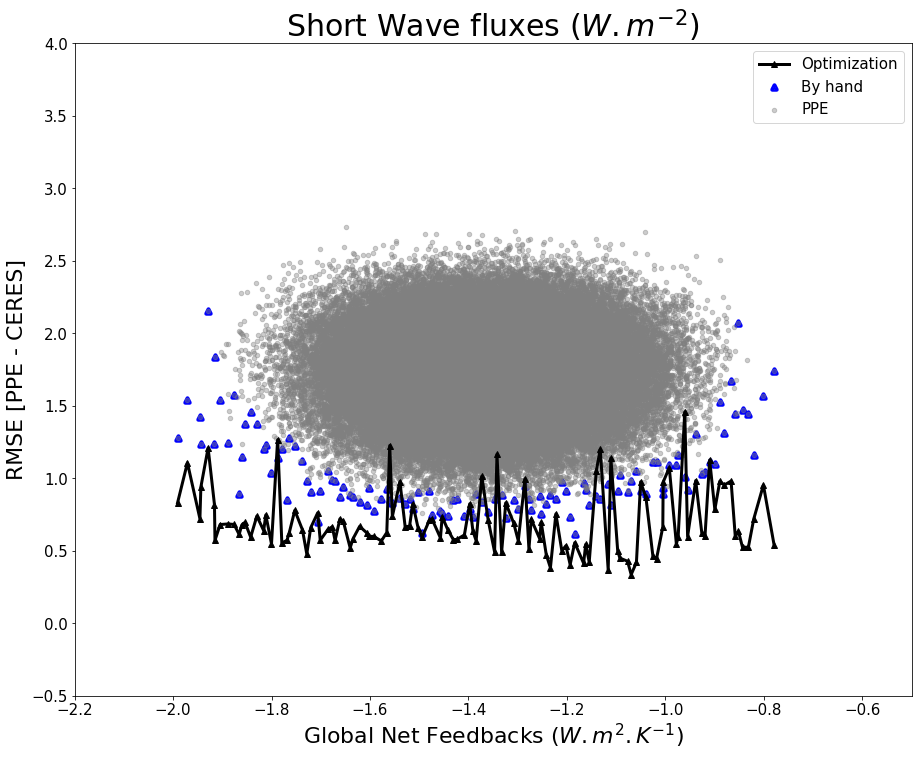

In [29]:
ax = plt.gca()


#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#E_multilinreg_val_df.plot(kind='scatter', x='Fdbck_val', y='E_multilinreg_val', color='black', alpha=1, figsize=(15, 12), 
#                     marker='x', ax = ax)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_lasso_pred_best', color = 'blue', 
         marker = '^', linewidth=4,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', 
         marker = '^', linewidth=3, ax = ax)

E_lasso_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_lasso_pred', 
                           color='gray', alpha=0.4, figsize=(15, 12), marker='o', ax = ax)

#E_lasso_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_lasso_pred', 
#                           color='lightblue', alpha=0.4, figsize=(15, 12), marker='o', ax = ax)

#E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
#                     marker="o", ax = ax)



#plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
#           linestyles='dashed')
#plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
#           linestyles='dashed')



legend = ['Optimization', 'By hand', 'PPE']

title = 'Short Wave fluxes ($W.m^{-2}$)'
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('RMSE [PPE - CERES]', fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/LASSO_RMSE_SW_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

# Likelihood

In [48]:
std_PPE = E_PPE_df['E_PPE'].std()
std_multilinreg = E_multilinreg_pred_df['E_multilinreg_pred'].std() 
std_lasso = E_lasso_pred_df['E_lasso_pred'].std() 
std_multilinreg

0.37128055596307924

In [60]:
OSE_multilinreg = sqrt((fluxes_biases['OSE_multilinreg']**2).mean())
tmp_multilinreg = (Likelihood_multilinreg['E_multilinreg_pred'])/(OSE_multilinreg)
toto = 1/(sqrt(2*pi*(OSE_multilinreg)))
Likelihood_multilinreg['likelihood_OSE'] = toto*e**(-tmp_multilinreg)

OSE_lasso = sqrt((fluxes_biases['OSE_lasso']**2).mean())
tmp_lasso = (Likelihood_lasso['E_lasso_pred'])/(OSE_lasso)
toto = 1/(sqrt(2*pi*(OSE_lasso)))
Likelihood_lasso['likelihood_OSE'] = toto*e**(-tmp_lasso)
Likelihood_lasso

,Fdbck_pred_round,E_lasso_pred,Fdbck_pred,likelihood_OSE
0,-1.8,1.739437,-1.799139,0.000965
1,-1.7,1.259936,-1.745091,0.006118
2,-1.6,0.952399,-1.649941,0.019995
3,-1.5,0.684269,-1.549999,0.056149
4,-1.4,0.649492,-1.449998,0.064195
5,-1.3,0.731298,-1.349999,0.046848
6,-1.2,0.737225,-1.249996,0.045791
7,-1.1,0.839962,-1.149988,0.030829
8,-1.0,1.271067,-1.049543,0.005861


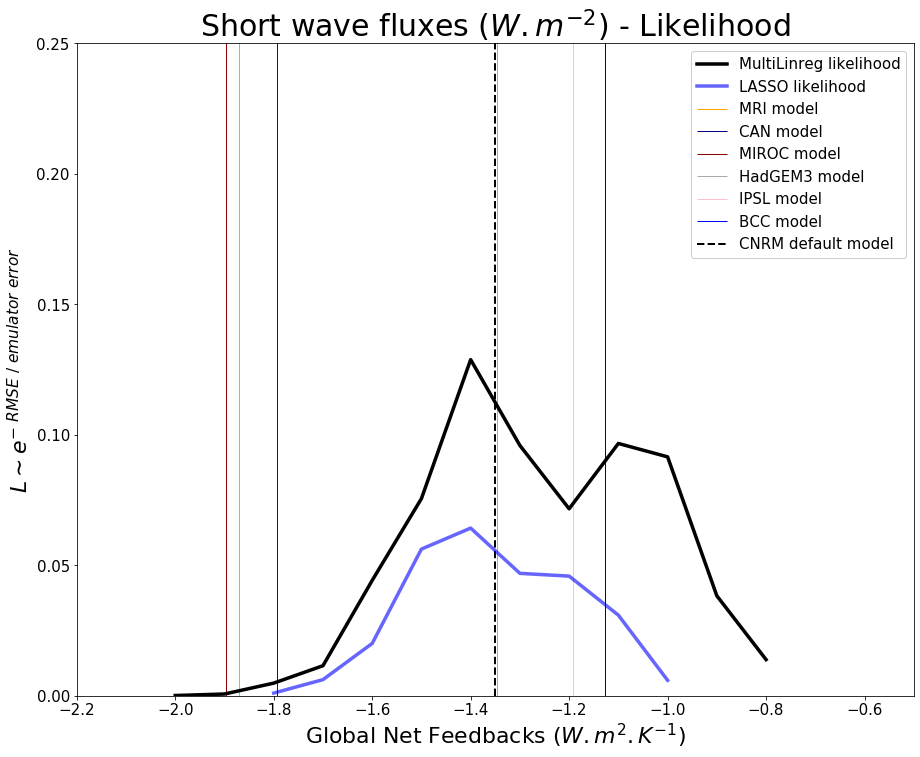

In [61]:
ax = plt.gca()

plt.vlines(Fdbck_MRI, ymin = 0,ymax = 25, color='orange', linestyles='solid', linewidth = 1)
plt.vlines(Fdbck_CAN, ymin = 0,ymax = 25, color='navy', linestyles='solid', linewidth = 1)
plt.vlines(Fdbck_MIROC, ymin = 0,ymax = 25, color='darkred', linestyles='solid', linewidth = 1)
plt.vlines(Fdbck_HadGEM3, ymin = 0,ymax = 25, color='darkgray', linestyles='solid', linewidth = 1)
plt.vlines(Fdbck_IPSL, ymin = 0,ymax = 25, color='pink', linestyles='solid', linewidth = 1)
plt.vlines(Fdbck_BCC, ymin = 0,ymax = 25, color='blue', linestyles='solid', linewidth = 1)

#Likelihood_multilinreg.plot(kind='line', x='Fdbck_pred_round', y='likelihood_std', color = 'black',figsize=(15, 12), 
#         linewidth = 3.5, ax = ax)
Likelihood_multilinreg.plot(kind='line', x='Fdbck_pred_round', y='likelihood_OSE', color = 'black',
         linewidth = 3.5, ax = ax)

#Likelihood_lasso.plot(kind='line', x='Fdbck_pred_round', y='likelihood_std', color = 'blue', alpha = 0.6,
#                      figsize=(15, 12), linewidth = 3.5, ax = ax)
Likelihood_lasso.plot(kind='line', x='Fdbck_pred_round', y='likelihood_OSE', color = 'blue', alpha = 0.6,
                      figsize=(15, 12), linewidth = 3.5, ax = ax)

plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth = 2)



legend = ['MultiLinreg likelihood', 'LASSO likelihood','MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model',  'CNRM default model']

title = 'Short wave fluxes ($W.m^{-2}$) - Likelihood'
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('$L \sim e^{-\ RMSE\ /\ emulator\ error}$', fontsize=22)
plt.legend(legend, fontsize=15, framealpha=1)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,0.25)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/likelihood_SW_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()